In [1]:
import numpy as np
import tensorflow as tf
import pennylane as qml

from sklearn.model_selection import train_test_split
from itertools import product
from src.learn import *
from src.quantum_recurrent_net import QuantumRNN

# Set common environment

In [2]:
bs = 4
class_n = 2
hidden_size = 3
input_size = 2

In [3]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate = 0.02)

In [4]:
def acc_fn(out, y):
    pred = tf.math.argmax(out, axis = 1)
    one_hot = np.zeros((pred.shape[0], class_n))
    one_hot[np.arange(pred.shape[0]), pred] = 1
    vector = one_hot 
    f = tf.cast(vector == y, tf.float32)
    return float(tf.reduce_mean(f))

In [5]:
def to_one_hot(X, y):
    X_one_hot = np.ones(list(X.shape) + [2])
    X_one_hot[:, :, 0] -= X
    X_one_hot[:, :, 1] = X
    
    y_one_hot = np.ones(list(y.shape) + [2])
    y_one_hot[:, 0] -= y
    y_one_hot[:, 1] = y
    
    return X_one_hot, y_one_hot
    

def get_all_XOR_data_all_comb(seq_len):
    x = [i for i in product(range(2), repeat = seq_len)]
    x = np.array(x)
    return to_one_hot(x, x.sum(axis = 1) % 2)


def get_rand_XOR_data(n, seq_len_min, seq_len_max, pad = 'pre'):
    x = np.random.randint(2, size=(n, seq_len_max)) #.astype('float32') 
    cuts = np.random.randint(low = seq_len_min - 1, high = seq_len_max, size = n)
    
    for i in range(n):
        x[i, : cuts[i]] = 0
    
    if pad == 'post':
        x = np.fliplr(x)
    return  to_one_hot(x, x.sum(axis = 1) % 2)

In [6]:
XOR_epoches = 100
X_xor, y_xor = get_all_XOR_data_all_comb(2)

xor_dataset = tf.data.Dataset.from_tensor_slices((X_xor, y_xor)).batch(bs)

In [7]:
seq_epoches = 30
X, y = get_rand_XOR_data(100, 4, 6)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(bs)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(bs)

# Train classical model for comparison

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(hidden_size),
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid),
])
tr_r, te_r, acc = learn(model, xor_dataset, xor_dataset, loss_fn, opt, metric_fn = acc_fn, epochs = XOR_epoches)


Start of epoch 0
Train and test losses: 0.2749, 0.2749
Metric: 0.7500

Start of epoch 1
Train and test losses: 0.2689, 0.2689
Metric: 0.7500

Start of epoch 2
Train and test losses: 0.2638, 0.2638
Metric: 0.7500

Start of epoch 3
Train and test losses: 0.2594, 0.2594
Metric: 0.5000

Start of epoch 4
Train and test losses: 0.2557, 0.2557
Metric: 0.5000

Start of epoch 5
Train and test losses: 0.2526, 0.2526
Metric: 0.5000

Start of epoch 6
Train and test losses: 0.2499, 0.2499
Metric: 0.5000

Start of epoch 7
Train and test losses: 0.2477, 0.2477
Metric: 0.5000

Start of epoch 8
Train and test losses: 0.2457, 0.2457
Metric: 0.5000

Start of epoch 9
Train and test losses: 0.2439, 0.2439
Metric: 0.5000

Start of epoch 10
Train and test losses: 0.2422, 0.2422
Metric: 0.5000

Start of epoch 11
Train and test losses: 0.2404, 0.2404
Metric: 0.5000

Start of epoch 12
Train and test losses: 0.2386, 0.2386
Metric: 0.5000

Start of epoch 13
Train and test losses: 0.2366, 0.2366
Metric: 0.5000

S

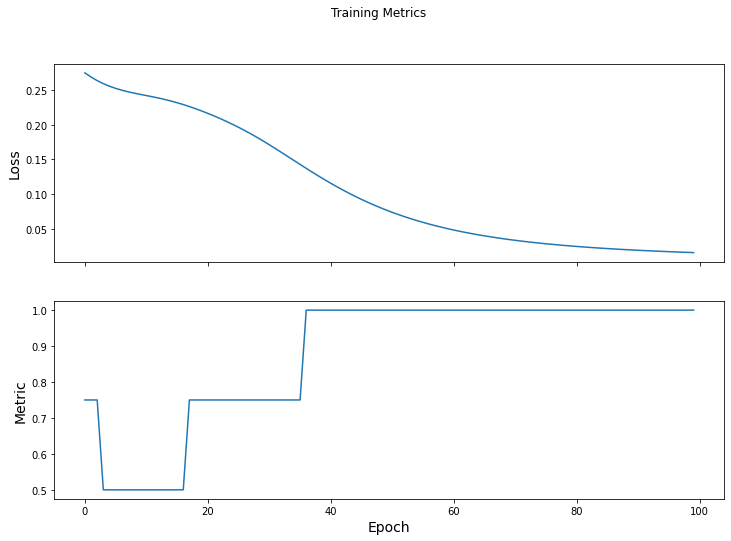

In [9]:
plot(te_r, acc)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(hidden_size),
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid),
])
tr_r, te_r, acc = learn(model, train_dataset, test_dataset, loss_fn, opt, metric_fn = acc_fn, epochs = seq_epoches)


Start of epoch 0
Train and test losses: 0.2338, 0.2100
Metric: 0.6786

Start of epoch 1
Train and test losses: 0.2069, 0.1763
Metric: 0.6786

Start of epoch 2
Train and test losses: 0.1789, 0.1500
Metric: 0.8214

Start of epoch 3
Train and test losses: 0.1635, 0.1343
Metric: 0.8214

Start of epoch 4
Train and test losses: 0.1557, 0.1262
Metric: 0.8214

Start of epoch 5
Train and test losses: 0.1509, 0.1215
Metric: 0.8214

Start of epoch 6
Train and test losses: 0.1475, 0.1185
Metric: 0.8214

Start of epoch 7
Train and test losses: 0.1449, 0.1163
Metric: 0.8214

Start of epoch 8
Train and test losses: 0.1429, 0.1148
Metric: 0.8214

Start of epoch 9
Train and test losses: 0.1412, 0.1135
Metric: 0.8214

Start of epoch 10
Train and test losses: 0.1394, 0.1121
Metric: 0.8214

Start of epoch 11
Train and test losses: 0.1310, 0.1081
Metric: 0.8214

Start of epoch 12
Train and test losses: 0.1119, 0.0922
Metric: 0.8214

Start of epoch 13
Train and test losses: 0.0938, 0.0801
Metric: 0.9286

S

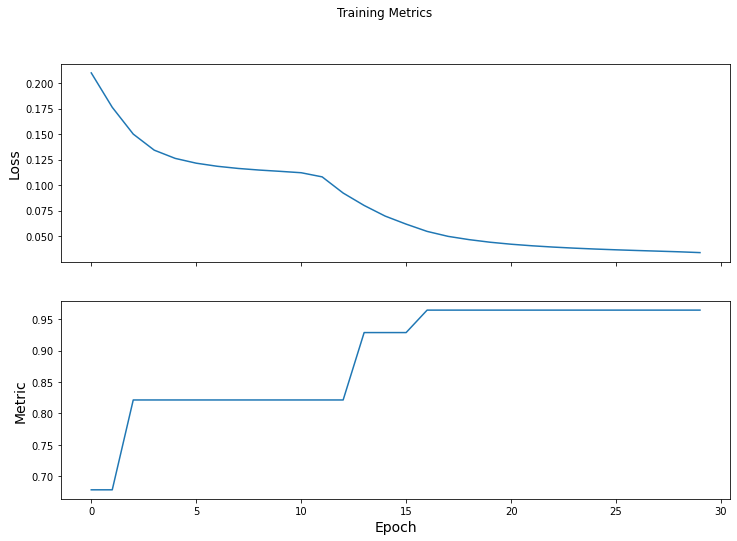

In [11]:
plot(te_r, acc)

# CV Quantum RNN

In [12]:
qml.enable_tape()
cutoff_dim = 6
dev = qml.device('strawberryfields.tf', cutoff_dim = cutoff_dim, wires = 5)
qml.enable_tape()

In [13]:
model = QuantumRNN(hidden_size, 2, dev = dev)
tr_r, te_r, acc = learn(model, xor_dataset, xor_dataset, loss_fn, opt, metric_fn = acc_fn, epochs = XOR_epoches)


Start of epoch 0
Train and test losses: 0.3142, 0.3142
Metric: 0.5000

Start of epoch 1
Train and test losses: 0.3584, 0.3584
Metric: 0.7500

Start of epoch 2
Train and test losses: 0.2878, 0.2878
Metric: 0.7500

Start of epoch 3
Train and test losses: 0.2286, 0.2286
Metric: 0.7500

Start of epoch 4
Train and test losses: 0.2429, 0.2429
Metric: 0.5000

Start of epoch 5
Train and test losses: 0.2504, 0.2504
Metric: 0.5000

Start of epoch 6
Train and test losses: 0.2279, 0.2279
Metric: 0.7500

Start of epoch 7
Train and test losses: 0.2014, 0.2014
Metric: 0.7500

Start of epoch 8
Train and test losses: 0.1904, 0.1904
Metric: 0.5000

Start of epoch 9
Train and test losses: 0.2017, 0.2017
Metric: 0.5000

Start of epoch 10
Train and test losses: 0.2048, 0.2048
Metric: 0.5000

Start of epoch 11
Train and test losses: 0.1966, 0.1966
Metric: 0.5000

Start of epoch 12
Train and test losses: 0.1957, 0.1957
Metric: 0.7500

Start of epoch 13
Train and test losses: 0.1932, 0.1932
Metric: 0.7500

S

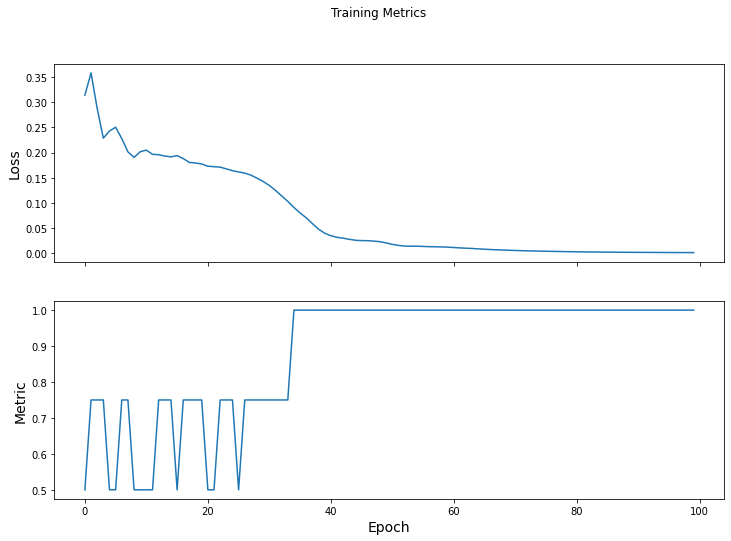

In [14]:
plot(te_r, acc)

In [ ]:
model = QuantumRNN(hidden_size, 2, dev = dev)
tr_r, te_r, acc = learn(model, train_dataset, test_dataset, loss_fn, opt, metric_fn = acc_fn, epochs = seq_epoches)


Start of epoch 0
Train and test losses: 0.2417, 0.2398
Metric: 0.6786

Start of epoch 1
Train and test losses: 0.2248, 0.2116
Metric: 0.8214

Start of epoch 2
Train and test losses: 0.2161, 0.2036
Metric: 0.6786

Start of epoch 3
Train and test losses: 0.2080, 0.1750
Metric: 0.6786

Start of epoch 4
Train and test losses: 0.1439, 0.1282
Metric: 0.6786

Start of epoch 5
Train and test losses: 0.1288, 0.1201
Metric: 0.6786

Start of epoch 6
Train and test losses: 0.1296, 0.1150
Metric: 0.8571

Start of epoch 7
Train and test losses: 0.1228, 0.1116
Metric: 0.7857

Start of epoch 8
Train and test losses: 0.0972, 0.0818
Metric: 0.9643

Start of epoch 9
Train and test losses: 0.0631, 0.0500
Metric: 0.9643

Start of epoch 10
Train and test losses: 0.0619, 0.0515
Metric: 0.9643

Start of epoch 11
Train and test losses: 0.0442, 0.0361
Metric: 0.9643

Start of epoch 12
Train and test losses: 0.0487, 0.0507
Metric: 0.9643

Start of epoch 13
Train and test losses: 0.0267, 0.0281
Metric: 0.9643

S

In [ ]:
plot(te_r, acc)